<a href="https://colab.research.google.com/github/noelsj007/Pneumonia_detection_model/blob/main/PneumoniaCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import tensorflow as tf


In [ ]:
main_path = "/content/drive/MyDrive/data/pneumoniadataset"

train_normal = glob(os.path.join(main_path, "train", "NORMAL", "*.jpeg"))
train_pneumonia = glob(os.path.join(main_path, "train", "PNEUMONIA", "*.jpeg"))

test_normal = glob(os.path.join(main_path, "test", "NORMAL", "*.jpeg"))
test_pneumonia = glob(os.path.join(main_path, "test", "PNEUMONIA", "*.jpeg"))

val_normal = glob(os.path.join(main_path, "val", "NORMAL", "*.jpeg"))
val_pneumonia = glob(os.path.join(main_path, "val", "PNEUMONIA", "*.jpeg"))


df_train = pd.DataFrame({
    'class': ['Normal'] * len(train_normal) + ['Pneumonia'] * len(train_pneumonia),
    'image': train_normal + train_pneumonia
})

df_test = pd.DataFrame({
    'class': ['Normal'] * len(test_normal) + ['Pneumonia'] * len(test_pneumonia),
    'image': test_normal + test_pneumonia
})

df_val = pd.DataFrame({
    'class': ['Normal'] * len(val_normal) + ['Pneumonia'] * len(val_pneumonia),
    'image': val_normal + val_pneumonia
})


In [ ]:
df_train

,class,image
0,Normal,/content/drive/MyDrive/data/pneumoniadataset/t...
1,Normal,/content/drive/MyDrive/data/pneumoniadataset/t...
2,Normal,/content/drive/MyDrive/data/pneumoniadataset/t...
3,Normal,/content/drive/MyDrive/data/pneumoniadataset/t...
4,Normal,/content/drive/MyDrive/data/pneumoniadataset/t...
...,...,...
5222,Pneumonia,/content/drive/MyDrive/data/pneumoniadataset/t...
5223,Pneumonia,/content/drive/MyDrive/data/pneumoniadataset/t...
5224,Pneumonia,/content/drive/MyDrive/data/pneumoniadataset/t...
5225,Pneumonia,/content/drive/MyDrive/data/pneumoniadataset/t...


Hyper parameter Tuning with the Variable set data


In [ ]:
import pandas as pd

df_train = pd.concat([df_train, df_val], axis=0)

# Reset the index
df_train = df_train.reset_index(drop=True)

In [ ]:
df_train

,class,image
0,Normal,/content/drive/MyDrive/data/pneumoniadataset/t...
1,Normal,/content/drive/MyDrive/data/pneumoniadataset/t...
2,Normal,/content/drive/MyDrive/data/pneumoniadataset/t...
3,Normal,/content/drive/MyDrive/data/pneumoniadataset/t...
4,Normal,/content/drive/MyDrive/data/pneumoniadataset/t...
...,...,...
5238,Pneumonia,/content/drive/MyDrive/data/pneumoniadataset/v...
5239,Pneumonia,/content/drive/MyDrive/data/pneumoniadataset/v...
5240,Pneumonia,/content/drive/MyDrive/data/pneumoniadataset/v...
5241,Pneumonia,/content/drive/MyDrive/data/pneumoniadataset/v...


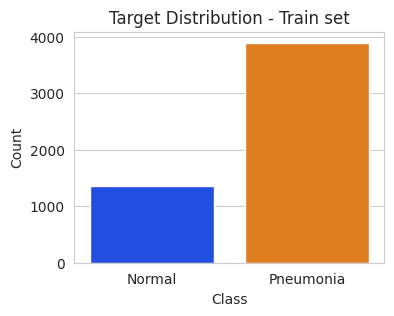

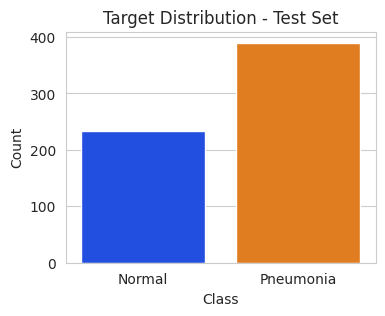

In [ ]:
sns.set_palette("bright")
sns.set_style("whitegrid")

# Plotting target distribution in the training set
plt.figure(figsize=(4,3))
sns.countplot(data=df_train, x='class')
plt.title('Target Distribution - Train set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Plotting target distribution in the test set
plt.figure(figsize=(4, 3))
sns.countplot(data=df_test, x='class')
plt.title('Target Distribution - Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Parameter tuning split the df_train DataFrame into validataion and training set for the processing with test_size 0.20 and train_size not set

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = 42, stratify = df_train['class'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale pixel values

# Create data generators
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32
)

ds_val = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32
)

ds_test = val_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1
)

Found 4194 validated image filenames belonging to 2 classes.
Found 1049 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), strides=1, padding='valid', activation='relu', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))

    model.add(Conv2D(64, (3, 3), strides=1, padding='valid', activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))

    model.add(Conv2D(64, (3, 3), strides=1, padding='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))

    model.add(Conv2D(128, (3, 3), strides=1, padding='valid', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))

    model.add(Conv2D(256, (3, 3), strides=1, padding='valid', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))

    model.add(Flatten())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))

    return model

In [ ]:
model = create_model()

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 109, 109, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     2

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-7,restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss',factor = 0.2,patience = 2,min_delt = 1e-7,cooldown = 0,verbose = 1)

In [ ]:
# Train the model with early stopping
history = model.fit(ds_train,
                    batch_size = 32,
                    epochs = 50,
                    validation_data=ds_val,
                    callbacks=[early_stopping, plateau],
                    steps_per_epoch=(len(train_df)/32),
                    validation_steps=(len(val_df)/32));

Epoch 1/50
131/131 [==============================] - 513s 4s/step - loss: 0.2152 - binary_accuracy: 0.9084 - val_loss: 1.6063 - val_binary_accuracy: 0.7426 - lr: 3.0000e-05
Epoch 2/50
100/131 [=====================>........] - ETA: 1:47 - loss: 0.2094 - binary_accuracy: 0.9164

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'], color='red', label='Train')
plt.plot(history.history['val_binary_accuracy'], color='blue', label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Accuracy)')
plt.show()

In [ ]:
plt.plot(history.history['loss'], color='red', label='Train')
plt.plot(history.history['val_loss'], color='blue', label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss)')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(ds_val,steps = int(len(ds_val)/32), verbose = 0)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(ds_test,steps = len(ds_test), verbose = 0)

# Get the predicted labels and true labels for the test dataset
test_labels = ds_test.labels
predicted_labels = model.predict(ds_test)

# Flatten the predicted labels to a 1D array
predicted_labels = np.round(predicted_labels).flatten()

# Calculate evaluation metrics
cm = confusion_matrix(test_labels, predicted_labels)
classification_rep = classification_report(test_labels, predicted_labels)

# Print the evaluation metrics
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_rep)